In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [32]:
def simulate(
    path, # the pre-calculated path with shape(t, 2)
    pref_loc, # preferred firing locations of the input neurons with shape(N_in, 2)
    dt = 0.01,
    N_in = 400, # number of input neurons
    N_out = 100, # number of output neurons
    n_snapshots = 20, # number of saved states of weights etc.
    tau_plus = 0.1,
    tau_minus = 0.3,
    a_0 = 0.1,
    s_0 = 0.3,
    errorbound = 0.1,
    sigma = 0.05,
    eta = 0.05,
    epsilon = 0.005,
    maxiterations = 1000,
    b3 = 0.01,
    b4 = 0.1,
    ):
    
    steps = path.shape[0]
    
    r_in = np.zeros(N_in, dtype=np.float64)
    r_out = np.zeros(N_out, dtype=np.float64)
    r_in_run = np.zeros(N_in, dtype=np.float64)
    r_out_run = np.zeros(N_out, dtype=np.float64)
    h = np.zeros(N_out, dtype=np.float64)
    r_plus = np.zeros(N_out, dtype=np.float64)
    r_minus = np.zeros(N_out, dtype=np.float64)
    w = np.random.uniform(size=(N_out, N_in))
    normalization = 1 / np.sqrt(np.sum(w ** 2.0, axis=1)) 
    np.multiply(w,normalization[:, np.newaxis], out=w)
    
    g_collect = np.zeros(steps, dtype=np.float64)
    mu_collect = np.zeros(steps, dtype=np.float64)
    
    for t in range(steps):
        
        np.exp(
            - np.sum((path[t, :] - pref_loc[:, :]) ** 2, axis=1) /
            (2 * sigma ** 2),
            out=r_in
        )
        
        np.add(r_in_run, eta * (r_in - r_in_run), out=r_in_run)        
        
        np.add(h, w.dot(r_in), out=h)        
        
        np.add(r_plus, dt * ((h - r_plus - r_minus) / tau_plus), out=r_plus)
        np.add(r_minus, dt * ((h - r_minus) / tau_minus), out=r_minus)
        
        mu = 0
        g = 1
        
        for it in range(maxiterations):
            
            np.multiply(
                2 / np.pi * np.arctan(g *  (r_plus - mu)),
                (0.5 * (np.sign(r_plus - mu) + 1)),
                out=r_out)
            
            a = np.mean(r_out)
            s = np.sum(r_out) ** 2 / (N_out * np.sum(r_out ** 2))
            
            # if bounds are met finish the iterative for loop
            if (((a_0 * (1 - errorbound)) <= a <= (a_0 * (1 + errorbound)))
                and ((s_0 * (1 - errorbound)) <= s <= (s_0 * (1 + errorbound)))):
                break     
                
            # else change mu and g
            mu += b3 * (a - a_0)
            g += b4 * g  * (s - s_0)
            
        g_collect[t] = g
        mu_collect[t] = mu
        
        # print(it, end=" ")
        np.add(r_out_run, eta * (r_out - r_out_run), out=r_out_run) 
        
        np.add(
            w,
            epsilon * (r_out[:, np.newaxis] * r_in[np.newaxis, :] -
                r_out_run[:, np.newaxis] * r_in[np.newaxis, :]),
            out=w)
        
        np.multiply(w, 1 / np.sum(w ** 2, axis=1)[:, np.newaxis], out=w)
        
        # print progress to console
        if t % int(np.ceil(steps / 1000)) == 0:
            print("\rSimulation at %.1f %%" % (t / steps * 100), end="")
    
    print(" Done!")
    return w, g_collect, mu_collect

In [33]:
path = np.load("rat_path_1h.npy")
# path = np.array([[0.6, 0.6], [0.61, 0.61]])


x_axis = np.linspace(0, 0.95, 20) #grid point spaced 5cm apart in meters
x, y = np.meshgrid(x_axis, x_axis)
pref_loc = np.vstack((x.flatten(),y.flatten())).T

limit_steps = 3600
weights, g, mu = simulate(path[0:limit_steps, :], pref_loc, N_in=400, N_out=100, dt=0.01)

Simulation at 13.1 %

C:\Users\Julius\Anaconda3\lib\site-packages\ipykernel\__main__.py:63: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Julius\Anaconda3\lib\site-packages\ipykernel\__main__.py:59: RuntimeWarning: invalid value encountered in sign


Simulation at 99.9 % Done!


C:\Users\Julius\Anaconda3\lib\site-packages\numpy\ma\core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


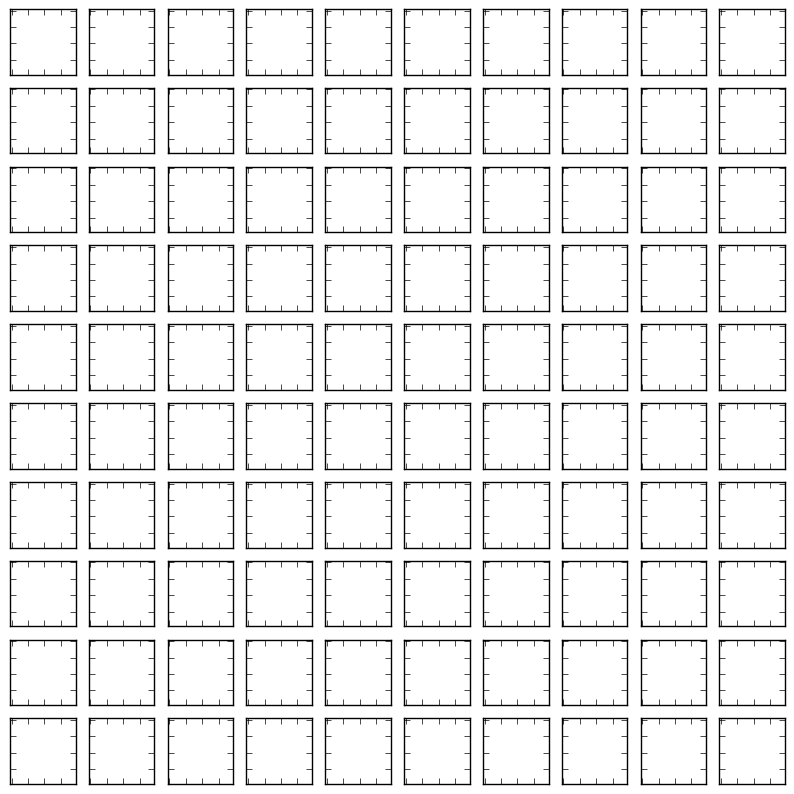

In [34]:
fig, sps = plt.subplots(10, 10)
for i, sp in enumerate(sps.flat):
    sp.imshow(weights.reshape(100,20,20)[i, ...].squeeze(), interpolation="None", cmap="jet")
    sp.set_xlabel("")
    sp.set_ylabel("")
    sp.set_xticklabels("")
    sp.set_yticklabels("")

fig.set_size_inches(10, 10)
plt.show()

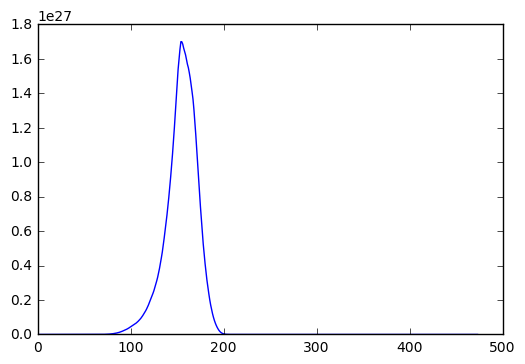

In [35]:
plt.plot(g)
plt.show()

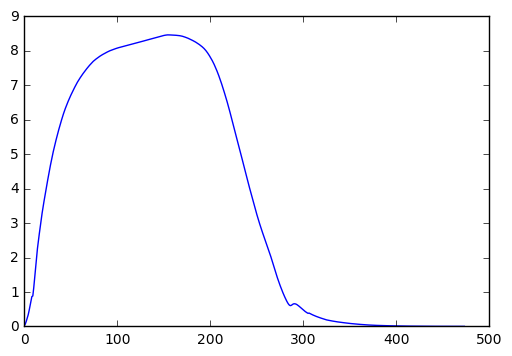

In [36]:
plt.plot(mu)
plt.show()